## Importing Libraries

In [1]:
import imageio
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

%matplotlib inline

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

## Configuring Paths

In [7]:
path = '../'
image_path = os.path.join(path,'data/train_images/')
mask_path = os.path.join(path,'data/train_masks/')

## Importing images and masks

In [8]:
image_names = sorted(os.listdir(image_path))
mask_names = sorted(os.listdir(mask_path))

In [9]:
image_list = [image_path+i for i in image_names]
mask_list = [mask_path+i for i in mask_names]

In [10]:
print('Total number of images = {}'.format(len(image_list)))
print('Total number of masks = {}'.format(len(mask_list)))

Total number of images = 261
Total number of masks = 261


## View an image and mask

In [11]:
N = 20
print('Image to be viewed: {}'.format(image_names[N]))
print('Mask to be viewed: {}'.format(mask_names[N]))

Image to be viewed: 6444.jpg
Mask to be viewed: 6444.png


Text(0.5, 1.0, 'Segmentation')

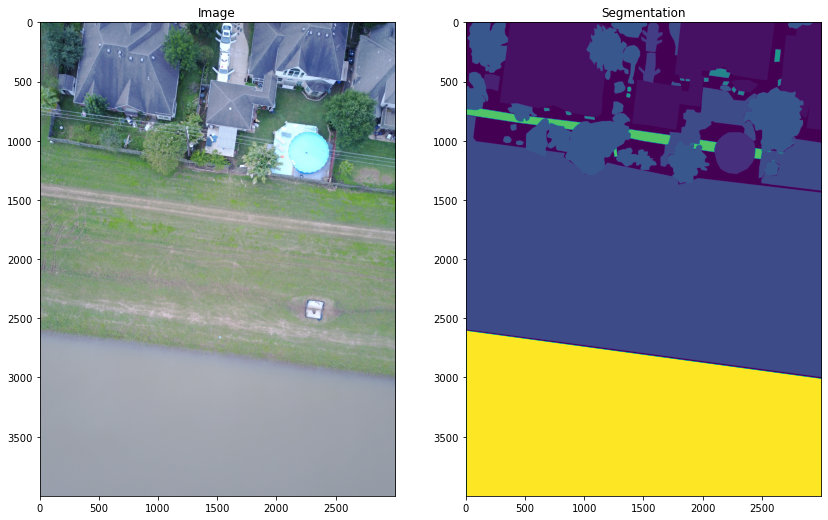

In [12]:
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

## Convert to Dataset

In [13]:
# Making tensors out of the list of strings of images and masks
image_list_tn = tf.constant(image_list)
mask_list_tn = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_list_tn, mask_list_tn))

2021-12-31 22:20:30.678516: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../data/train_images/10172.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/train_masks/10172.png', shape=(), dtype=string)


In [15]:
def process_path(image_path, mask_path):
    print(image_path)
    print(mask_path)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)



#TO BE TRIED:
#     # Normalize the values
#     X = X.astype('float32')
#     X = (X / X.max() - 0.5) * 2   # put X in range [-1, 1]
#     Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
#     test_size = test_size/float(training_size+test_size)
    
#     X_train, X_val, Y_train, Y_val = train_test_split(
#         X, Y, test_size=test_size, random_state=42)
    
#     return X_train, Y_train, X_val, Y_val

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


In [16]:
for i, m in image_ds.take(1):
    print("Size of IMAGE pre-processing: {}".format(i.shape))
    print("Size of MASK pre-processing: {}".format(m.shape))
print("++++++++++++++++++++++++++++++++++++++++++")
for i, m in processed_image_ds.take(1):
    print("Size of IMAGE post-processing: {}".format(i.shape))
    print("Size of MASK post-processing: {}".format(m.shape))

Size of IMAGE pre-processing: (4000, 3000, 3)
Size of MASK pre-processing: (4000, 3000, 1)
++++++++++++++++++++++++++++++++++++++++++
Size of IMAGE post-processing: (256, 256, 3)
Size of MASK post-processing: (256, 256, 1)


In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4000, 3000, 1)


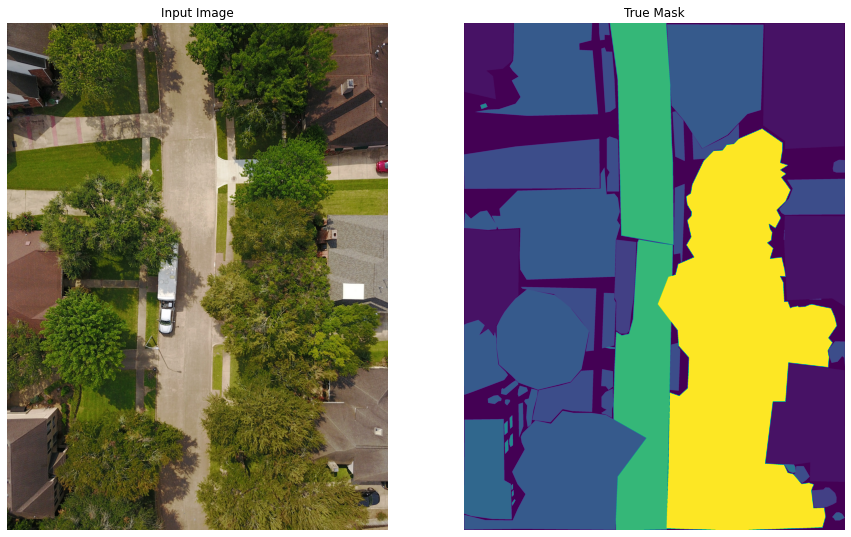

In [18]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(256, 256, 1)


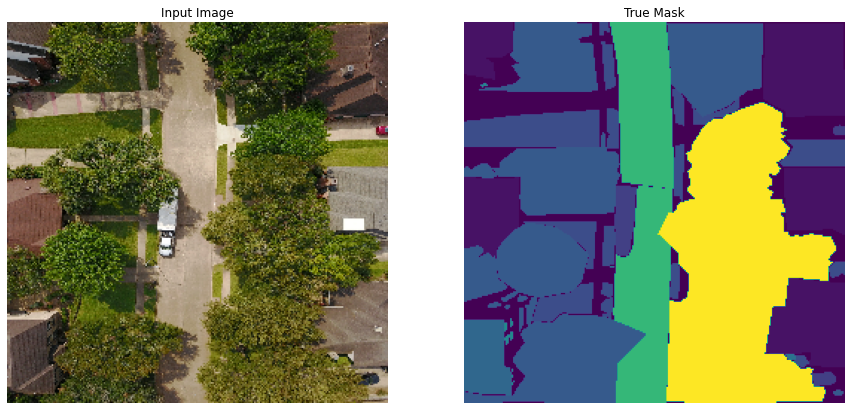

In [19]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Building the UNet model

In [20]:
INPUT_SIZE = 256
N_CLASSES = 25
N_CHANNEL = 3

def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [21]:
unet = get_unet()

In [22]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [23]:
# In semantic segmentation, you need as many masks as you have object classes. 
# In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
# certain class - 0 to 24. The correct class is the layer with the higher probability. 

# Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
# lots of classes and to perform pixel-wise multiclass prediction. 

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
print(type(image_ds))
print(type(processed_image_ds))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


## Creating necessary callbacks

In [2]:
change the folder path before training!

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "checkpoints/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

NameError: name 'os' is not defined

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('Evaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('Evaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

## Training the model

In [25]:
EPOCHS = 20
# VAL_SUBSPLITS = 5
BUFFER_SIZE = 300
BATCH_SIZE = 20
# processed_image_ds.batch(BATCH_SIZE)

In [26]:
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)


(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


In [ ]:
model_history = unet.fit(train_dataset, epochs=EPOCHS, callbacks=[MyCustomCallback(),cp_callback])

Epoch 1/20
Training: batch 0 begins at 22:21:02.419151


2021-12-31 22:21:14.241553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 50 of 300
2021-12-31 22:21:24.290450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 100 of 300
2021-12-31 22:21:34.470177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 148 of 300
2021-12-31 22:21:44.334027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 193 of 300
2021-12-31 22:21:54.412382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 243 of 300
2021-12-31 22:21:58.181985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


Training: batch 0 ends at 22:22:29.739102
      1/Unknown - 87s 87s/step - loss: 3.2188 - accuracy: 0.0467Training: batch 1 begins at 22:22:29.742052
Training: batch 1 ends at 22:23:00.329673
      2/Unknown - 118s 59s/step - loss: 3.2179 - accuracy: 0.0649Training: batch 2 begins at 22:23:00.330854


In [4]:
save_weights_location = "saved_weights/training_1/"
unet.save_weights(save_weights_location)